In [ ]:
# Install necessary packages
import os
import ee
import geemap
!pip install matplotlib numpy pandas seaborn scipy cartopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 54.1 MB/s eta 0:00:00


In [ ]:
ee.Authenticate()
ee.Initialize(
    project = 'gee-project-436010',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!



Loading GRACE MASCON data globally...
Number of images: 238
Time period: 2002-04-03 to 2024-09-30
Time span: 22.49 years

CALCULATING LINEAR TRENDS FOR EACH MASCON
This will take 2-3 minutes to compute trends globally...
Running linear regression...
✓ Linear regression complete!
  Trend band name: ['trend']
✓ Statistical metrics calculated!

ANALYZING GLOBAL PATTERNS

Regional average trends (cm/year):

Region                    Trend (cm/yr)   Interpretation
----------------------------------------------------------------------
Greenland                   -5.610        Strong water loss ⚠️
Antarctica                No data        
Amazon Basin                 0.006        Relatively stable ➡️
Central Africa               0.763        Water gain 📈
India/South Asia            -0.210        Relatively stable ➡️
Western US                  -0.280        Relatively stable ➡️
Central Asia                -0.678        Moderate water loss 📉
Australia                    0.184        Relativel

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…


SAMPLING DATA FOR VISUALIZATION
Creating sample grid with optimized spacing...
  Created 5880 sample points
Sampling trend values efficiently using sampleRegions...
This will take 1-2 minutes...
Fetching data from Earth Engine...
(If you see retry warnings, don't worry - Earth Engine will automatically retry)
Error fetching data: Collection query aborted after accumulating over 5000 elements.
Trying with even fewer points...
  Created 3330 sample points
✓ Successfully fetched 3330 samples!
Converting to pandas DataFrame...
✓ Successfully processed 3330 points

Trend statistics from sampled data:
count    3330.000000
mean       -0.167696
std         3.585629
min      -117.588422
25%         0.044624
50%         0.191248
75%         0.276529
max         6.317003
Name: trend, dtype: float64

GENERATING PUBLICATION-QUALITY MAPS
✓ Saved: global_grace_trends.png


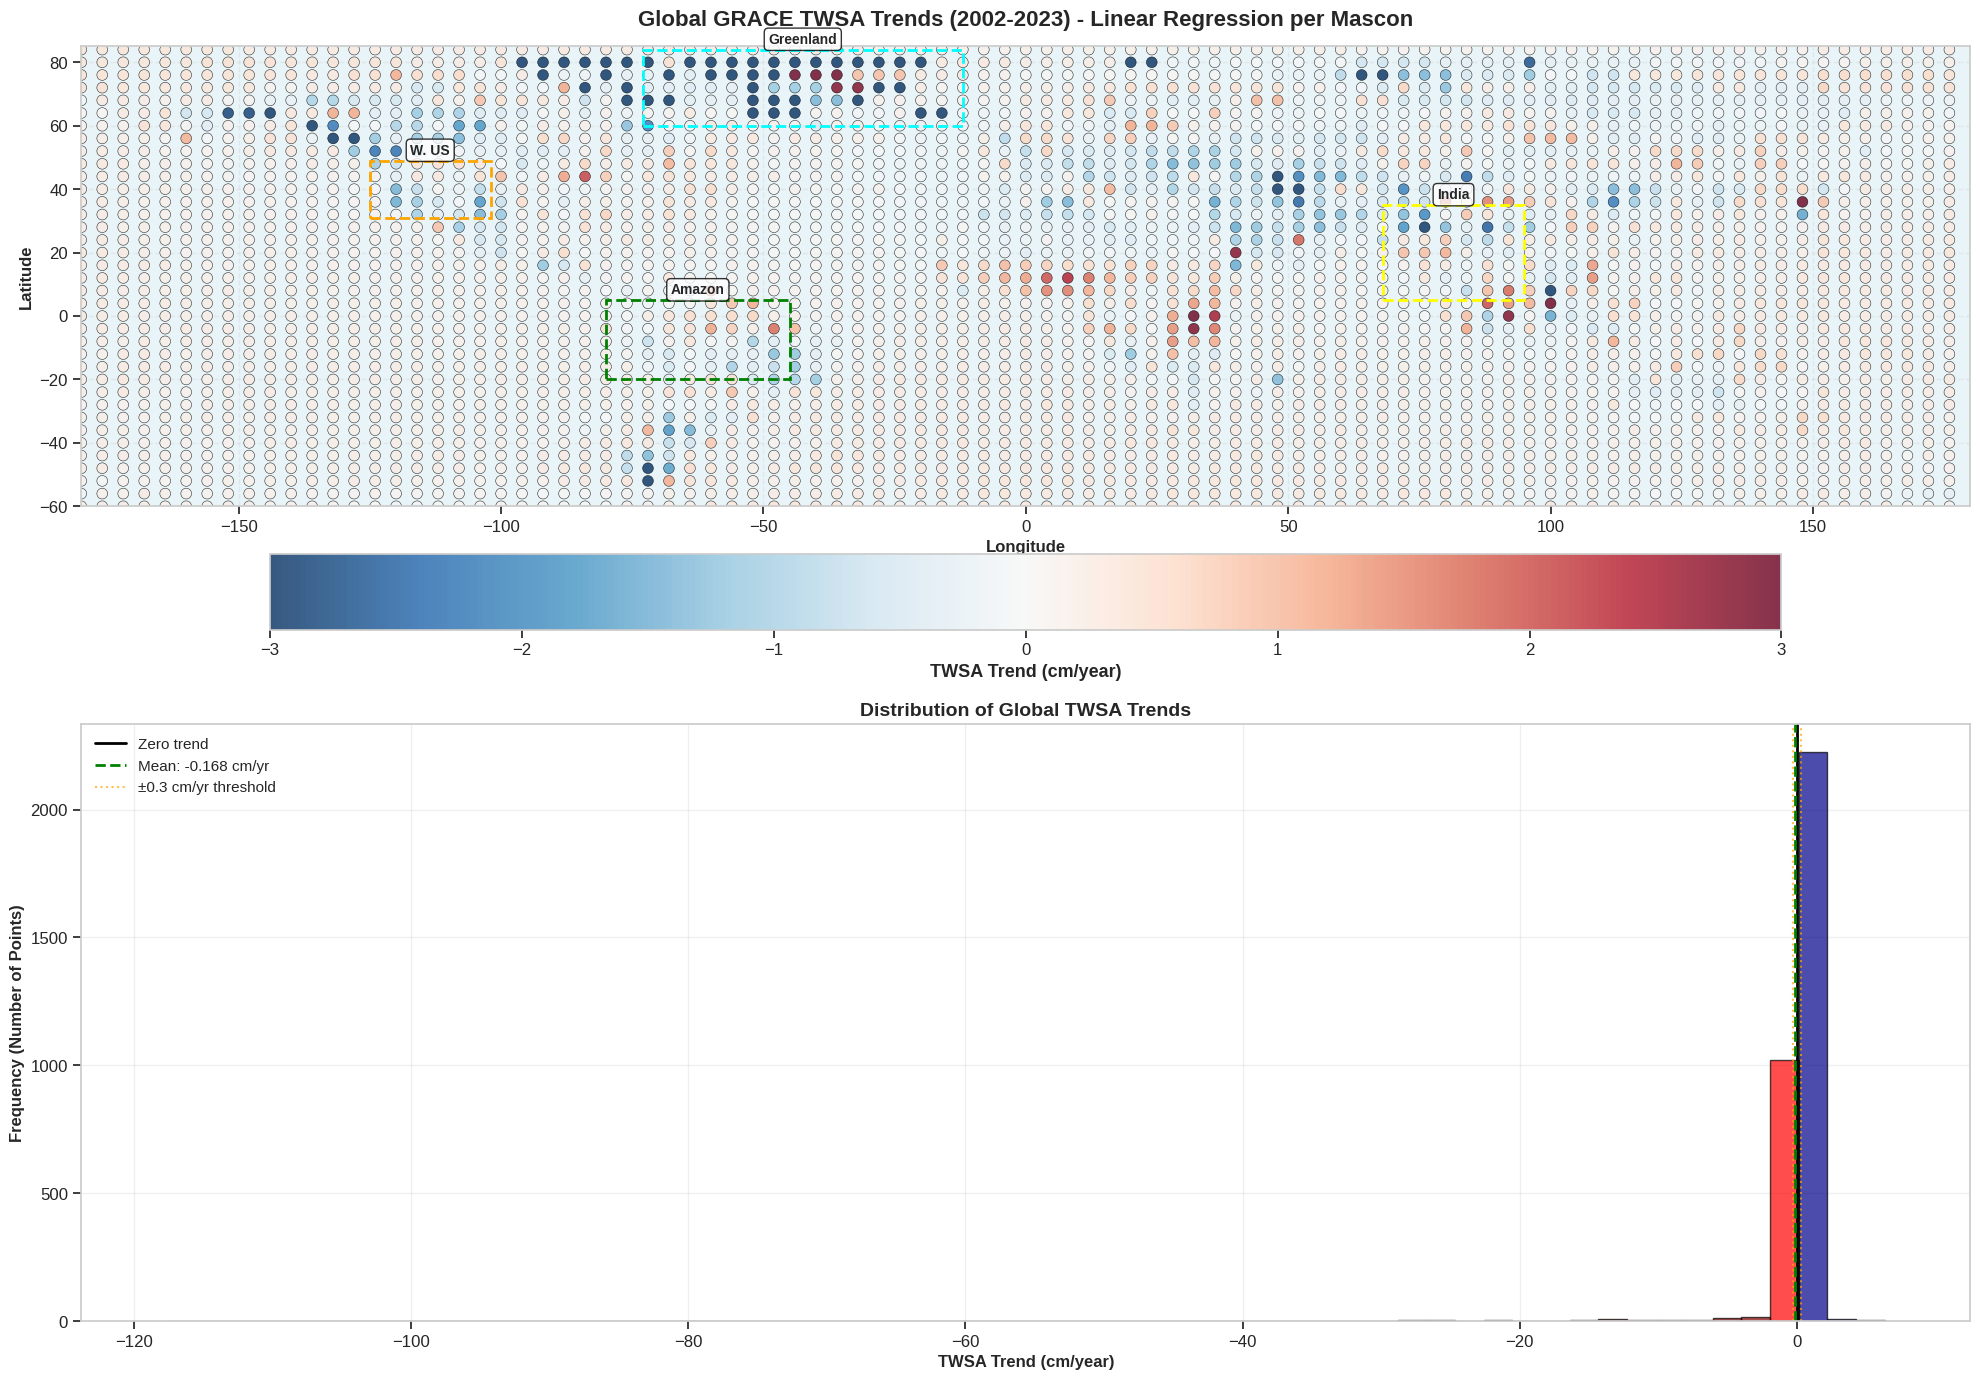

✓ Saved: regional_trends_comparison.png


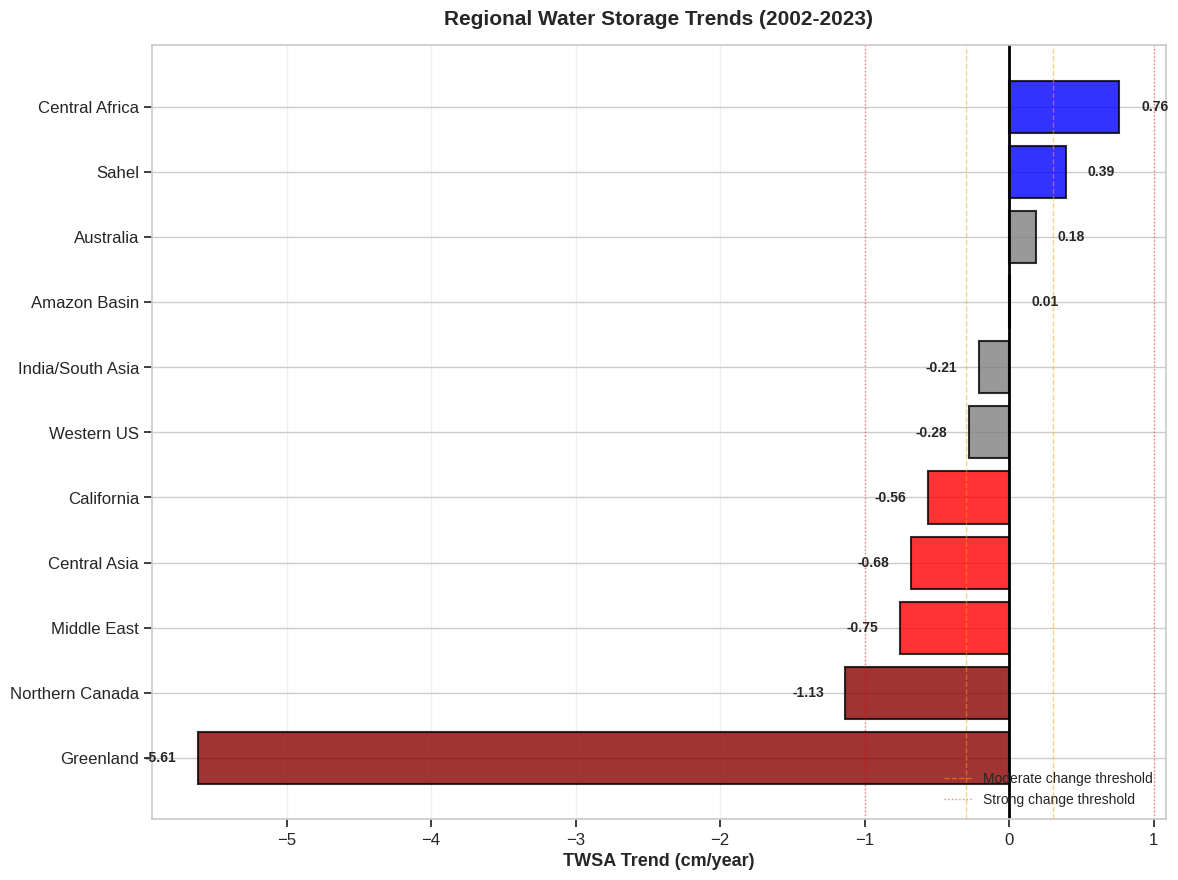


CLIMATE PHENOMENA AND LARGE-SCALE PATTERNS

🌍 KEY FINDINGS AND INTERPRETATIONS:

1. STRONGEST WATER LOSSES (RED REGIONS):
   • Greenland: -5.61 cm/year
   • Northern Canada: -1.13 cm/year
   • Middle East: -0.75 cm/year
   • Central Asia: -0.68 cm/year
   • California: -0.56 cm/year

2. STRONGEST WATER GAINS (BLUE REGIONS):
   • Central Africa: 0.76 cm/year

3. RELATIVELY STABLE REGIONS (WHITE AREAS):
   • Amazon Basin: 0.01 cm/year
   • India/South Asia: -0.21 cm/year
   • Western US: -0.28 cm/year
   • Australia: 0.18 cm/year

4. CONNECTIONS TO CLIMATE PHENOMENA:

   🌊 ENSO (El Niño-Southern Oscillation) Impacts:
      - Amazon Basin: Interannual variability linked to ENSO cycles
      - Drought periods in SE Asia during strong El Niño events
      - Increased rainfall in western South America during El Niño
      - Australia: Wet La Niña vs dry El Niño patterns

   ❄️ GLACIER AND ICE SHEET MELT:
      - Greenland: Strong negative trends from ice sheet melting
      - Antarctica: Re

In [ ]:

# GRACE Global TWSA Trend Analysis - EFFICIENT SAMPLING VERSION
# Calculate linear trends for each mascon and visualize globally

# ============================================================================
# LOAD GRACE DATA GLOBALLY
# ============================================================================
print("\nLoading GRACE MASCON data globally...")

grace = (
    ee.ImageCollection("NASA/GRACE/MASS_GRIDS_V04/MASCON_CRI")
    .filterDate('2002-04-01', '2024-12-31')
    .select('lwe_thickness')
)

# Get collection info
num_images = grace.size().getInfo()
dates_list = grace.aggregate_array('system:time_start').getInfo()
first_date = pd.to_datetime(min(dates_list), unit='ms')
last_date = pd.to_datetime(max(dates_list), unit='ms')
time_span_years = (last_date - first_date).days / 365.25

print(f"Number of images: {num_images}")
print(f"Time period: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
print(f"Time span: {time_span_years:.2f} years")

# ============================================================================
# CALCULATE LINEAR TREND FOR EACH PIXEL/MASCON
# ============================================================================
print("\n" + "="*70)
print("CALCULATING LINEAR TRENDS FOR EACH MASCON")
print("="*70)
print("This will take 2-3 minutes to compute trends globally...")

# Add time band to each image
def add_time_band(image):
    """Add a time band to each image (years since start of dataset)"""
    date = ee.Date(image.get('system:time_start'))
    years = date.difference(ee.Date('2002-04-01'), 'year')
    time_band = ee.Image(years).rename('time').float()
    return image.addBands(time_band)

# Add time bands to all images
grace_with_time = grace.map(add_time_band)

# Use linearFit reducer
print("Running linear regression...")
linear_fit = grace_with_time.select(['time', 'lwe_thickness']).reduce(
    ee.Reducer.linearFit()
)

# Extract results and rename for clarity
trend_slope = linear_fit.select('scale').rename('trend')
trend_offset = linear_fit.select('offset').rename('intercept')

print("✓ Linear regression complete!")
print(f"  Trend band name: {trend_slope.bandNames().getInfo()}")

# Calculate additional statistics
mean_twsa = grace.select('lwe_thickness').mean()
std_twsa = grace.select('lwe_thickness').reduce(ee.Reducer.stdDev())

print("✓ Statistical metrics calculated!")

# ============================================================================
# CALCULATE STATISTICS AND IDENTIFY HOTSPOTS
# ============================================================================
print("\n" + "="*70)
print("ANALYZING GLOBAL PATTERNS")
print("="*70)

# Define regions of interest
regions = {
    'Greenland': ee.Geometry.Rectangle([-73, 60, -12, 84]),
    'Antarctica': ee.Geometry.Rectangle([-180, -90, 180, -60]),
    'Amazon Basin': ee.Geometry.Rectangle([-80, -20, -45, 5]),
    'Central Africa': ee.Geometry.Rectangle([10, -10, 35, 10]),
    'India/South Asia': ee.Geometry.Rectangle([68, 5, 95, 35]),
    'Western US': ee.Geometry.Rectangle([-125, 31, -102, 49]),
    'Central Asia': ee.Geometry.Rectangle([45, 35, 95, 55]),
    'Australia': ee.Geometry.Rectangle([110, -45, 155, -10]),
    'Northern Canada': ee.Geometry.Rectangle([-140, 55, -60, 75]),
    'Sahel': ee.Geometry.Rectangle([-18, 10, 45, 20]),
    'Middle East': ee.Geometry.Rectangle([35, 15, 60, 40]),
    'California': ee.Geometry.Rectangle([-125, 32, -114, 42]),
}

print("\nRegional average trends (cm/year):\n")
print(f"{'Region':<25} {'Trend (cm/yr)':<15} {'Interpretation'}")
print("-" * 70)

regional_stats = {}
for region_name, region_geom in regions.items():
    try:
        result = trend_slope.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_geom,
            scale=50000,
            maxPixels=1e9,
            bestEffort=True
        )

        trend_value = result.get('trend')

        if trend_value is not None:
            trend_value = ee.Number(trend_value).getInfo()

        regional_stats[region_name] = trend_value

        if trend_value is not None and not np.isnan(trend_value):
            if trend_value < -1.0:
                interpretation = "Strong water loss ⚠️"
            elif trend_value < -0.3:
                interpretation = "Moderate water loss 📉"
            elif trend_value < 0.3:
                interpretation = "Relatively stable ➡️"
            else:
                interpretation = "Water gain 📈"

            print(f"{region_name:<25} {trend_value:>8.3f}        {interpretation}")
        else:
            print(f"{region_name:<25} {'No data':<15}")
            regional_stats[region_name] = None
    except Exception as e:
        print(f"{region_name:<25} Error: {str(e)[:30]}")
        regional_stats[region_name] = None

# Calculate global statistics
print("\nCalculating global statistics...")
try:
    global_stats = trend_slope.reduceRegion(
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.mean(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=ee.Geometry.Rectangle([-180, -60, 180, 85]),
        scale=50000,
        maxPixels=1e10,
        bestEffort=True
    )

    stats_info = global_stats.getInfo()

    print("\n" + "="*70)
    print("GLOBAL STATISTICS (excluding high polar regions)")
    print("="*70)

    min_val = stats_info.get('trend_min')
    max_val = stats_info.get('trend_max')
    mean_val = stats_info.get('trend_mean')
    std_val = stats_info.get('trend_stdDev')

    print(f"Minimum trend: {min_val:.3f} cm/year" if min_val is not None else "Minimum trend: N/A")
    print(f"Maximum trend: {max_val:.3f} cm/year" if max_val is not None else "Maximum trend: N/A")
    print(f"Mean trend: {mean_val:.3f} cm/year" if mean_val is not None else "Mean trend: N/A")
    print(f"Std deviation: {std_val:.3f} cm/year" if std_val is not None else "Std deviation: N/A")

except Exception as e:
    print(f"Error calculating global statistics: {e}")
    stats_info = {}

# ============================================================================
# CREATE INTERACTIVE MAP
# ============================================================================
print("\n" + "="*70)
print("CREATING INTERACTIVE MAP")
print("="*70)

# Create map
map_global = geemap.Map(center=[20, 0], zoom=2)

# Define visualization parameters
vis_params_trend = {
    'min': -3.0,
    'max': 3.0,
    'palette': [
        '8B0000',  # Dark red (strong loss)
        'FF0000',  # Red
        'FF6347',  # Tomato
        'FFA500',  # Orange
        'FFFF00',  # Yellow
        'FFFFFF',  # White (no change)
        'ADD8E6',  # Light blue
        '4169E1',  # Royal blue
        '00008B'   # Dark blue (strong gain)
    ]
}

vis_params_mean = {
    'min': -10,
    'max': 10,
    'palette': ['blue', 'white', 'red']
}

# Add layers to map
map_global.addLayer(trend_slope, vis_params_trend, 'TWSA Trend (cm/year)', True, opacity=0.8)
map_global.addLayer(mean_twsa, vis_params_mean, 'Mean TWSA (cm)', False, opacity=0.7)
map_global.addLayer(std_twsa, {'min': 0, 'max': 10, 'palette': ['white', 'yellow', 'red']},
                   'Standard Deviation (cm)', False, opacity=0.7)

# Add region boundaries
for region_name, region_geom in regions.items():
    map_global.addLayer(region_geom, {'color': 'yellow'}, region_name, False)

# Add colorbar
map_global.add_colorbar(vis_params_trend, label='TWSA Trend (cm/year)',
                       orientation='horizontal', transparent_bg=True)

print("✓ Interactive map created!")
print("  Red colors = Water loss")
print("  Blue colors = Water gain")
print("  White = Stable")
display(map_global)

# ============================================================================
# SAMPLE DATA FOR PLOTTING - EFFICIENT METHOD USING SAMPLEREGIONS
# ============================================================================
print("\n" + "="*70)
print("SAMPLING DATA FOR VISUALIZATION")
print("="*70)

print("Creating sample grid with optimized spacing...")

# Use larger spacing to reduce data volume (3-4 degrees instead of 2)
spacing = 3  # 3-degree spacing = ~1,500 points (much more manageable)

# Create sample points as a FeatureCollection
def create_sample_grid_efficient(spacing_degrees=3):
    """Create a regular grid of point features with larger spacing"""
    features = []
    point_count = 0
    for lon in range(-180, 180, spacing_degrees):
        for lat in range(-60, 85, spacing_degrees):
            point = ee.Geometry.Point([lon, lat])
            feature = ee.Feature(point, {'lon': lon, 'lat': lat})
            features.append(feature)
            point_count += 1
    print(f"  Created {point_count} sample points")
    return ee.FeatureCollection(features)

sample_points = create_sample_grid_efficient(spacing_degrees=spacing)

# Use sampleRegions for efficient sampling (much faster than mapping!)
print("Sampling trend values efficiently using sampleRegions...")
print("This will take 1-2 minutes...")

# Create a multi-band image with all variables we want to sample
sample_image = ee.Image.cat([
    trend_slope.rename('trend'),
    mean_twsa.rename('mean_twsa'),
    std_twsa.rename('std_twsa')
])

# Use sampleRegions - much more efficient!
sampled_data = sample_image.sampleRegions(
    collection=sample_points,
    scale=50000,
    geometries=True
)

print("Fetching data from Earth Engine...")
print("(If you see retry warnings, don't worry - Earth Engine will automatically retry)")

# Fetch data with error handling
try:
    sampled_list = sampled_data.getInfo()['features']
    print(f"✓ Successfully fetched {len(sampled_list)} samples!")
except Exception as e:
    print(f"Error fetching data: {e}")
    print("Trying with even fewer points...")
    # Fall back to larger spacing if needed
    sample_points = create_sample_grid_efficient(spacing_degrees=4)
    sampled_data = sample_image.sampleRegions(
        collection=sample_points,
        scale=50000,
        geometries=True
    )
    sampled_list = sampled_data.getInfo()['features']
    print(f"✓ Successfully fetched {len(sampled_list)} samples!")

# Convert to pandas DataFrame
print("Converting to pandas DataFrame...")
data_list = []
for feature in sampled_list:
    props = feature['properties']
    if props.get('trend') is not None:
        data_list.append({
            'lon': props.get('lon'),
            'lat': props.get('lat'),
            'trend': props['trend'],
            'mean_twsa': props.get('mean_twsa'),
            'std_twsa': props.get('std_twsa')
        })

df_global = pd.DataFrame(data_list)
df_global = df_global.dropna(subset=['trend'])

print(f"✓ Successfully processed {len(df_global)} points")
print(f"\nTrend statistics from sampled data:")
print(df_global['trend'].describe())

# ============================================================================
# CREATE PUBLICATION-QUALITY MAPS
# ============================================================================
print("\n" + "="*70)
print("GENERATING PUBLICATION-QUALITY MAPS")
print("="*70)

# Figure 1: Global trend map
fig, axes = plt.subplots(2, 1, figsize=(20, 14))

# Main map: TWSA Trends
ax1 = axes[0]

scatter = ax1.scatter(df_global['lon'], df_global['lat'],
                     c=df_global['trend'],
                     s=60,  # Slightly larger points since fewer of them
                     cmap='RdBu_r',
                     vmin=-3, vmax=3,
                     alpha=0.8,
                     edgecolors='black',
                     linewidth=0.4)

ax1.set_xlim(-180, 180)
ax1.set_ylim(-60, 85)
ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#E8F4F8')

cbar = plt.colorbar(scatter, ax=ax1, orientation='horizontal', pad=0.08, shrink=0.8)
cbar.set_label('TWSA Trend (cm/year)', fontsize=13, fontweight='bold')
ax1.set_title('Global GRACE TWSA Trends (2002-2023) - Linear Regression per Mascon',
             fontsize=16, fontweight='bold', pad=15)

# Add key region boxes
region_boxes = {
    'Greenland': {'bounds': [-73, -12, 60, 84], 'color': 'cyan'},
    'Amazon': {'bounds': [-80, -45, -20, 5], 'color': 'green'},
    'India': {'bounds': [68, 95, 5, 35], 'color': 'yellow'},
    'W. US': {'bounds': [-125, -102, 31, 49], 'color': 'orange'},
}

for name, info in region_boxes.items():
    x1, x2, y1, y2 = info['bounds']
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                         fill=False, edgecolor=info['color'],
                         linewidth=2, linestyle='--')
    ax1.add_patch(rect)
    ax1.text((x1+x2)/2, y2+2, name,
            fontsize=10, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Histogram of trends
ax2 = axes[1]
counts, bins, patches = ax2.hist(df_global['trend'], bins=60,
                                 color='steelblue', alpha=0.7, edgecolor='black')

# Color bars by value
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center < -1:
        patch.set_facecolor('darkred')
    elif bin_center < -0.3:
        patch.set_facecolor('red')
    elif bin_center < 0.3:
        patch.set_facecolor('gray')
    elif bin_center < 1:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('darkblue')

ax2.axvline(0, color='black', linestyle='-', linewidth=2, label='Zero trend')
ax2.axvline(df_global['trend'].mean(), color='green', linestyle='--', linewidth=2,
           label=f'Mean: {df_global["trend"].mean():.3f} cm/yr')
ax2.axvline(-0.3, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='±0.3 cm/yr threshold')
ax2.axvline(0.3, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

ax2.set_xlabel('TWSA Trend (cm/year)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency (Number of Points)', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Global TWSA Trends', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('global_grace_trends.png', dpi=300, bbox_inches='tight')
print("✓ Saved: global_grace_trends.png")
plt.show()

# ============================================================================
# REGIONAL COMPARISON CHART
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 9))

# Filter out None values and sort
filtered_stats = {k: v for k, v in regional_stats.items() if v is not None}
sorted_regions = sorted(filtered_stats.items(), key=lambda x: x[1])
region_names = [r[0] for r in sorted_regions]
region_values = [r[1] for r in sorted_regions]

# Color code by loss/gain
colors = []
for v in region_values:
    if v < -1:
        colors.append('darkred')
    elif v < -0.3:
        colors.append('red')
    elif v < 0.3:
        colors.append('gray')
    elif v < 1:
        colors.append('blue')
    else:
        colors.append('darkblue')

bars = ax.barh(region_names, region_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.axvline(-0.3, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Moderate change threshold')
ax.axvline(0.3, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Strong change threshold')
ax.axvline(1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('TWSA Trend (cm/year)', fontsize=13, fontweight='bold')
ax.set_title('Regional Water Storage Trends (2002-2023)', fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')
ax.legend(fontsize=10, loc='lower right')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, region_values)):
    offset = 0.15 if value > 0 else -0.15
    ax.text(value + offset, i, f'{value:.2f}',
           va='center', ha='left' if value > 0 else 'right',
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('regional_trends_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: regional_trends_comparison.png")
plt.show()

# ============================================================================
# CLIMATE PHENOMENA ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("CLIMATE PHENOMENA AND LARGE-SCALE PATTERNS")
print("="*70)

print("\n🌍 KEY FINDINGS AND INTERPRETATIONS:\n")

print("1. STRONGEST WATER LOSSES (RED REGIONS):")
losses = [(k, v) for k, v in filtered_stats.items() if v < -0.5]
losses.sort(key=lambda x: x[1])
for region, trend in losses:
    print(f"   • {region}: {trend:.2f} cm/year")

print("\n2. STRONGEST WATER GAINS (BLUE REGIONS):")
gains = [(k, v) for k, v in filtered_stats.items() if v > 0.5]
gains.sort(key=lambda x: x[1], reverse=True)
for region, trend in gains:
    print(f"   • {region}: {trend:.2f} cm/year")

print("\n3. RELATIVELY STABLE REGIONS (WHITE AREAS):")
stable = [(k, v) for k, v in filtered_stats.items() if -0.3 <= v <= 0.3]
for region, trend in stable:
    print(f"   • {region}: {trend:.2f} cm/year")

print("\n4. CONNECTIONS TO CLIMATE PHENOMENA:")

print("\n   🌊 ENSO (El Niño-Southern Oscillation) Impacts:")
print("      - Amazon Basin: Interannual variability linked to ENSO cycles")
print("      - Drought periods in SE Asia during strong El Niño events")
print("      - Increased rainfall in western South America during El Niño")
print("      - Australia: Wet La Niña vs dry El Niño patterns")

print("\n   ❄️ GLACIER AND ICE SHEET MELT:")
print("      - Greenland: Strong negative trends from ice sheet melting")
print("      - Antarctica: Regional variations (West vs East Antarctic)")
print("      - Central Asia: Mountain glacier melt (Tien Shan, Pamir)")
print("      - Andes, Himalayas, Alps: Visible glacier retreat signals")

print("\n   🏜️ DROUGHT AND GROUNDWATER DEPLETION:")
print("      - Western US: Prolonged megadrought since ~2000")
print("      - California: Severe groundwater extraction")
print("      - India (NW): Intensive irrigation-driven depletion")
print("      - Middle East: Unsustainable groundwater use")
print("      - Mediterranean: Declining water storage")

print("\n   💧 PRECIPITATION AND HYDROLOGICAL CHANGES:")
print("      - Sahel: Recovery from historical droughts (1970s-80s)")
print("      - Northern high latitudes: Increased precipitation")
print("      - Some tropical regions: Enhanced monsoon intensity")
print("      - Parts of Central Africa: Rainfall variability")

print("\n" + "="*70)
print("SPATIAL PATTERNS SUMMARY")
print("="*70)

# Categorize sampled points
df_global['category'] = pd.cut(df_global['trend'],
                                bins=[-np.inf, -1, -0.3, 0.3, 1, np.inf],
                                labels=['Strong Loss', 'Moderate Loss', 'Stable',
                                       'Moderate Gain', 'Strong Gain'])

print("\nGlobal distribution of trends:")
category_counts = df_global['category'].value_counts().sort_index()
print(category_counts)
print(f"\nPercentage with significant loss (< -0.3 cm/yr): {(df_global['trend'] < -0.3).sum() / len(df_global) * 100:.1f}%")
print(f"Percentage with significant gain (> 0.3 cm/yr): {(df_global['trend'] > 0.3).sum() / len(df_global) * 100:.1f}%")
print(f"Percentage relatively stable (-0.3 to 0.3): {((df_global['trend'] >= -0.3) & (df_global['trend'] <= 0.3)).sum() / len(df_global) * 100:.1f}%")

# ============================================================================
# HOTSPOT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("HOTSPOT IDENTIFICATION")
print("="*70)

# Find extreme loss and gain hotspots
extreme_loss = df_global[df_global['trend'] < df_global['trend'].quantile(0.05)]
extreme_gain = df_global[df_global['trend'] > df_global['trend'].quantile(0.95)]

print(f"\n🔴 TOP 10 STRONGEST LOSS HOTSPOTS:")
top_losses = extreme_loss.nsmallest(10, 'trend')
for idx, row in top_losses.iterrows():
    print(f"   Lat: {row['lat']:6.1f}°, Lon: {row['lon']:7.1f}° | Trend: {row['trend']:.2f} cm/year")

print(f"\n🔵 TOP 10 STRONGEST GAIN HOTSPOTS:")
top_gains = extreme_gain.nlargest(10, 'trend')
for idx, row in top_gains.iterrows():
    print(f"   Lat: {row['lat']:6.1f}°, Lon: {row['lon']:7.1f}° | Trend: {row['trend']:.2f} cm/year")

# ============================================================================
# EXPORT DATA
# ============================================================================
print("\n" + "="*70)
print("EXPORTING DATA")
print("="*70)

# Save sampled data to CSV
df_global.to_csv('grace_global_trends_sampled.csv', index=False)
print("✓ Saved: grace_global_trends_sampled.csv")

# Save regional statistics
regional_df = pd.DataFrame(list(filtered_stats.items()),
                           columns=['Region', 'Trend_cm_per_year'])
regional_df = regional_df.sort_values('Trend_cm_per_year')
regional_df.to_csv('grace_regional_trends.csv', index=False)
print("✓ Saved: grace_regional_trends.csv")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\n📊 Summary:")
print(f"  • Analyzed {num_images} GRACE images over {time_span_years:.1f} years")
print(f"  • Sampled {len(df_global)} points globally")
print(f"  • Analyzed {len(filtered_stats)} regions in detail")
print(f"  • Global mean trend: {df_global['trend'].mean():.3f} cm/year")
print(f"  • Strongest loss: {df_global['trend'].min():.2f} cm/year")
print(f"  • Strongest gain: {df_global['trend'].max():.2f} cm/year")

print("\n🗺️ Use the interactive map above to explore any region in detail!")
print("   Red = Water loss | Blue = Water gain | White = Stable")
